In [1]:
import pickle
import pandas as pd
import numpy
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
with open('date_for_ts.pickle','rb') as f:
    df = pickle.load(f)

In [3]:
df.tail()

,time
7507,2018-08-04
7508,2020-01-02
7509,2019-02-01
7510,2018-08-11
7511,2018-11-01


In [4]:
df = df[df.time.dt.year>2017]

In [5]:
ts1 = df.resample('W-MON',on='time').count()

In [6]:
ts1 = ts1[:-1]

In [7]:
ts1 = ts1[1:]

In [8]:

from warnings import simplefilter

import numpy as np
import pandas as pd

from sktime.datasets import load_airline
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import (
    MeanAbsolutePercentageError,
    mean_absolute_percentage_error,
)
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
%matplotlib inline

In [9]:
ts1.shape

(169, 1)

In [10]:
ts1.index = ts1.index.to_period()

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='time'>)

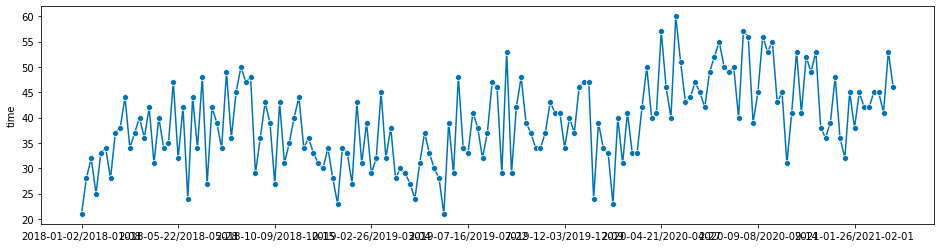

In [11]:
y = ts1.time
plot_series(y)

In [14]:
max_date = max(ts1.index).strftime('%Y-%m-%d')
max_date

'2021-03-29'

In [15]:
min_date = min(ts1.index).strftime('%Y-%m-%d')
min_date

'2018-01-08'

99 70


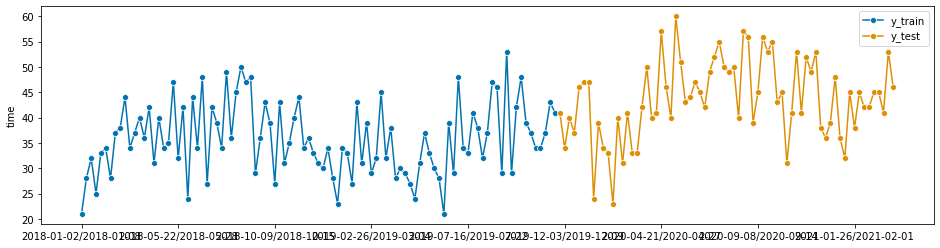

In [16]:

y_train, y_test = temporal_train_test_split(y, test_size=70)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [17]:
max_train = max(y_train.index).strftime('%Y-%m-%d')
max_train

'2019-11-25'

In [22]:
fh_1 = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range(max_date, periods=12, freq="W-MON")), is_relative=False
)


# fh = ForecastingHorizon(
#     pd.PeriodIndex(pd.date_range(max_train, periods=70, freq="W-MON")), is_relative=False
#  )

fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range(min_date, periods=169, freq="W-MON")), is_relative=False
 )


In [23]:
fh

ForecastingHorizon(['2018-01-02/2018-01-08', '2018-01-09/2018-01-15',
             '2018-01-16/2018-01-22', '2018-01-23/2018-01-29',
             '2018-01-30/2018-02-05', '2018-02-06/2018-02-12',
             '2018-02-13/2018-02-19', '2018-02-20/2018-02-26',
             '2018-02-27/2018-03-05', '2018-03-06/2018-03-12',
             ...
             '2021-01-19/2021-01-25', '2021-01-26/2021-02-01',
             '2021-02-02/2021-02-08', '2021-02-09/2021-02-15',
             '2021-02-16/2021-02-22', '2021-02-23/2021-03-01',
             '2021-03-02/2021-03-08', '2021-03-09/2021-03-15',
             '2021-03-16/2021-03-22', '2021-03-23/2021-03-29'],
            dtype='period[W-MON]', length=169, freq='W-MON', is_relative=False)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='time'>)

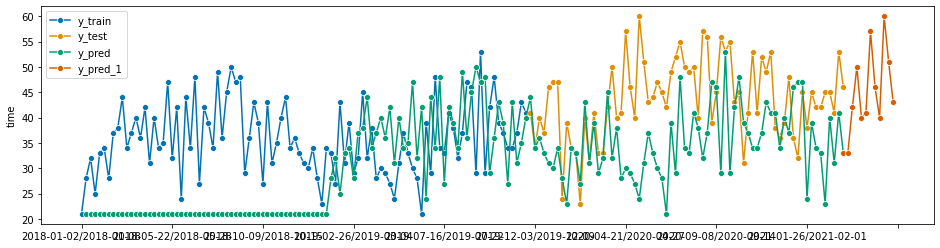

In [50]:
forecaster = NaiveForecaster(strategy="last",sp=54)
forecaster.fit(y)
y_pred = forecaster.predict(fh)
y_pred_1 = forecaster.predict(fh_1)
plot_series(y_train,y_test, y_pred,y_pred_1, labels=["y_train","y_test","y_pred","y_pred_1"])
#mean_absolute_percentage_error(y_pred, y)

<AxesSubplot:xlabel='index,index'>

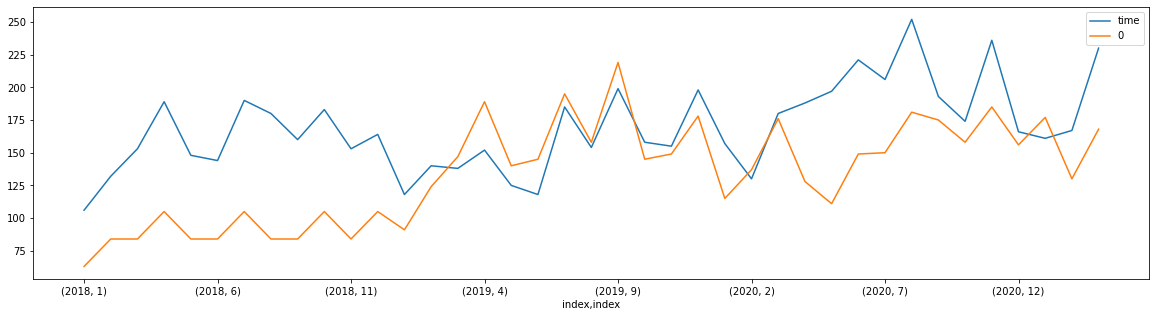

In [51]:
zzz = pd.concat([pd.DataFrame(y),pd.DataFrame(y_pred)],axis=1).reset_index()
#zzz['index'] = pd.to_datetime(zzz['index'])
zzz.groupby([zzz['index'].dt.year,zzz['index'].dt.month]).sum().plot(figsize=(20,5))

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='time'>)

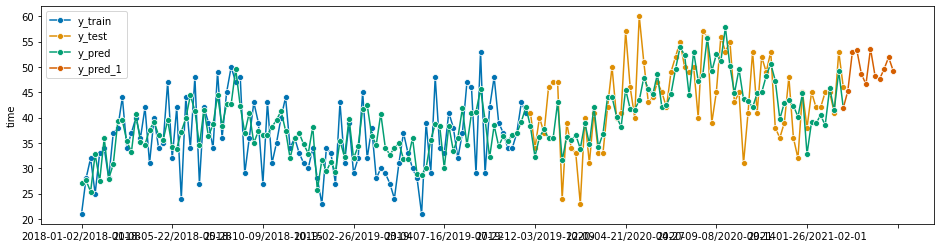

In [28]:

forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=54)
forecaster.fit(y)
y_pred = forecaster.predict(fh)
y_pred_1 = forecaster.predict(fh_1)
plot_series(y_train,y_test, y_pred,y_pred_1, labels=["y_train","y_test","y_pred","y_pred_1"])
#mean_absolute_percentage_error(y_pred, y_test)

<AxesSubplot:xlabel='index,index'>

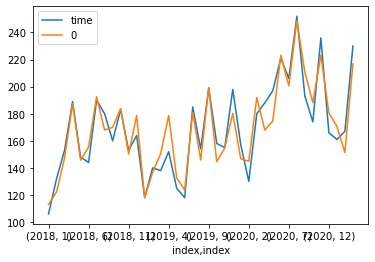

In [29]:
zzz = pd.concat([pd.DataFrame(y),pd.DataFrame(y_pred)],axis=1).reset_index()
#zzz['index'] = pd.to_datetime(zzz['index'])
zzz.groupby([zzz['index'].dt.year,zzz['index'].dt.month]).sum().plot()

In [30]:

forecaster = AutoARIMA(sp=54, suppress_warnings=True)
forecaster.fit(y)
y_pred = forecaster.predict(fh)
y_pred_1 = forecaster.predict(fh_1)
plot_series(y_train,y_test, y_pred,y_pred_1, labels=["y_train","y_test","y_pred","y_pred_1"])
#mean_absolute_percentage_error(y_pred, y_test)

C:\Users\olga\anaconda3\lib\site-packages\pmdarima\arima\arima.py:577: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


ValueError: In-sample predictions undefined for start=0 when d=1

<AxesSubplot:xlabel='index,index'>

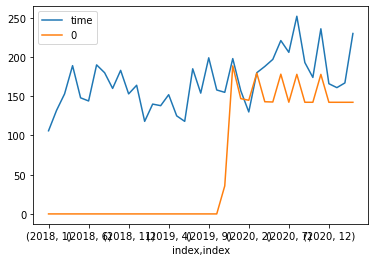

In [24]:
zzz = pd.concat([pd.DataFrame(y),pd.DataFrame(y_pred)],axis=1).reset_index()
#zzz['index'] = pd.to_datetime(zzz['index'])
zzz.groupby([zzz['index'].dt.year,zzz['index'].dt.month]).sum().plot()

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='time'>)

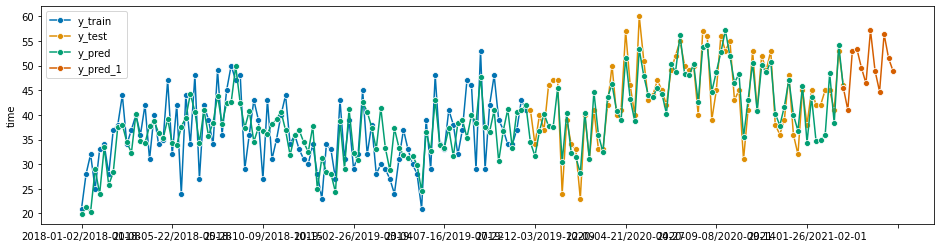

In [32]:
from sktime.forecasting.bats import BATS

forecaster = BATS(sp=54, use_trend=True, use_box_cox=True)
forecaster.fit(y)
y_pred = forecaster.predict(fh)
y_pred_1 = forecaster.predict(fh_1)
plot_series(y_train,y_test, y_pred,y_pred_1, labels=["y_train","y_test","y_pred","y_pred_1"])
#mean_absolute_percentage_error(y_pred, y_test)

<AxesSubplot:xlabel='index,index'>

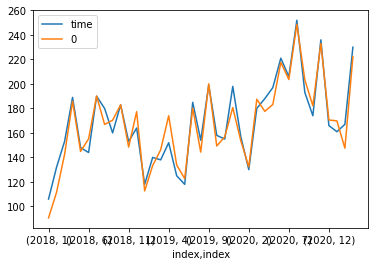

In [33]:
zzz = pd.concat([pd.DataFrame(y),pd.DataFrame(y_pred)],axis=1).reset_index()
#zzz['index'] = pd.to_datetime(zzz['index'])
zzz.groupby([zzz['index'].dt.year,zzz['index'].dt.month]).sum().plot()

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='time'>)

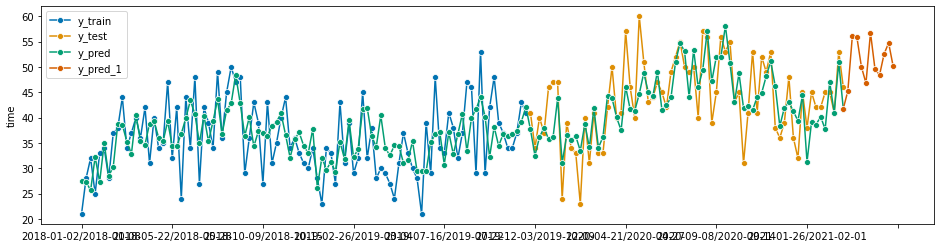

In [35]:
from sktime.forecasting.compose import EnsembleForecaster
forecaster = EnsembleForecaster([
    ("ses", ExponentialSmoothing(seasonal="multiplicative", sp=54)),
    ("holt", ExponentialSmoothing(trend="add",  seasonal="multiplicative", sp=54)),
    ("damped", ExponentialSmoothing(trend="add",  seasonal="multiplicative", sp=54))
])
forecaster.fit(y)
y_pred = forecaster.predict(fh)
y_pred_1 = forecaster.predict(fh_1)
plot_series(y_train,y_test, y_pred,y_pred_1, labels=["y_train","y_test","y_pred","y_pred_1"])
#mean_absolute_percentage_error(y_pred, y_test)

<AxesSubplot:xlabel='index,index'>

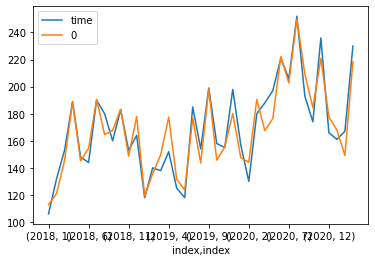

In [36]:
zzz = pd.concat([pd.DataFrame(y),pd.DataFrame(y_pred)],axis=1).reset_index()
#zzz['index'] = pd.to_datetime(zzz['index'])
zzz.groupby([zzz['index'].dt.year,zzz['index'].dt.month]).sum().plot()

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='time'>)

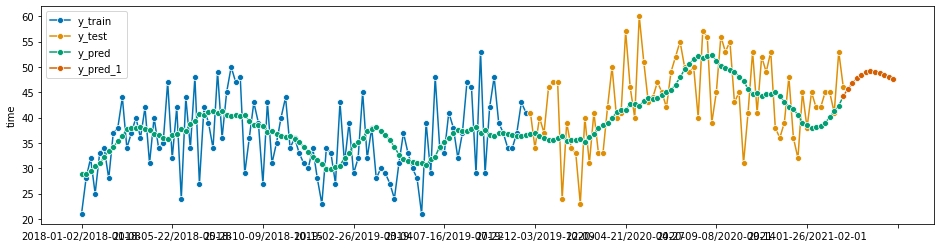

In [37]:
from sktime.forecasting.tbats import TBATS

forecaster = TBATS(sp=54, use_trend=True, use_box_cox=True)
forecaster.fit(y)
y_pred = forecaster.predict(fh)
y_pred_1 = forecaster.predict(fh_1)
plot_series(y_train,y_test, y_pred,y_pred_1, labels=["y_train","y_test","y_pred","y_pred_1"])
#mean_absolute_percentage_error(y_pred, y_test)

<AxesSubplot:xlabel='index,index'>

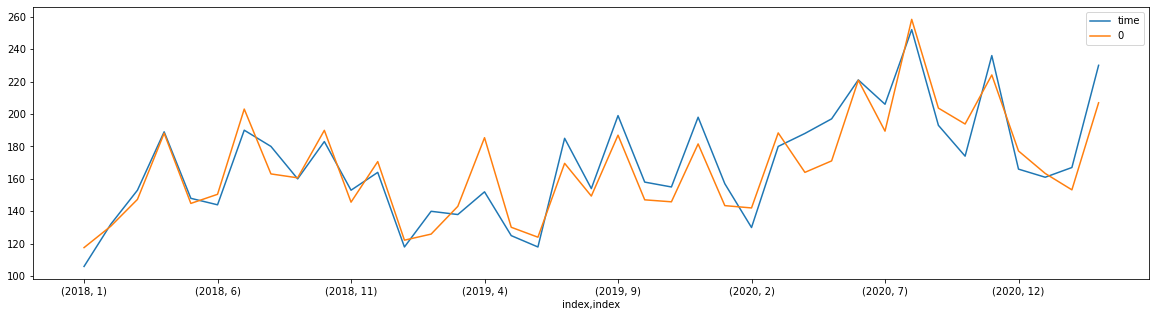

In [38]:
zzz = pd.concat([pd.DataFrame(y),pd.DataFrame(y_pred)],axis=1).reset_index()
#zzz['index'] = pd.to_datetime(zzz['index'])
zzz.groupby([zzz['index'].dt.year,zzz['index'].dt.month]).sum().plot(figsize=(20,5))

In [39]:
# Convert index to pd.DatetimeIndex
z = y.copy()
z = z.to_timestamp(freq="W-MON")
z_train, z_test = temporal_train_test_split(z, test_size=30)

In [44]:
fh_1z = ForecastingHorizon(
    pd.date_range(max_date, periods=12, freq="W-MON"), is_relative=False
)


fhz = ForecastingHorizon(
    pd.date_range(min_date, periods=168, freq="W-MON"), is_relative=False
 )


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='time'>)

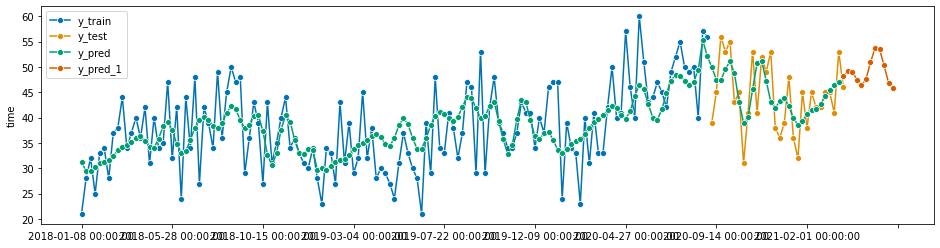

In [45]:
from sktime.forecasting.fbprophet import Prophet
forecaster = Prophet(
    seasonality_mode="multiplicative",
    n_changepoints=int(len(y_train) / 8),
    add_country_holidays={"country_name": "Ukraine"},
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=True,
)
forecaster.fit(z)
y_pred = forecaster.predict(fhz)
y_pred_1 = forecaster.predict(fh_1z)
plot_series(z_train,z_test, y_pred,y_pred_1, labels=["y_train","y_test","y_pred","y_pred_1"])
#mean_absolute_percentage_error(y_pred, y_test)

In [ ]:
y_pred_1.sum()

<AxesSubplot:xlabel='index,index'>

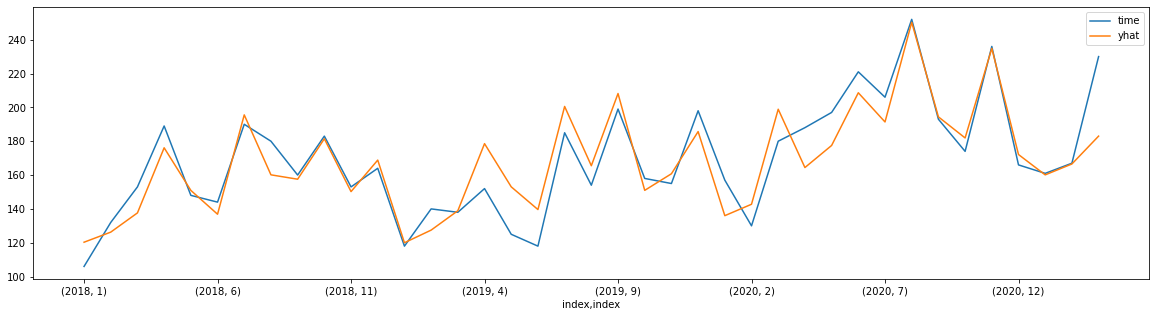

In [47]:
zzz = pd.concat([pd.DataFrame(z),pd.DataFrame(y_pred)],axis=1).reset_index()
zzz['index'] = pd.to_datetime(zzz['index'])
zzz.groupby([zzz['index'].dt.year,zzz['index'].dt.month]).sum().plot(figsize=(20,5))